In [1]:
import numpy as np
from pylab import *
import torch
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from torch import nn
import random
import math
from torch.utils.data import DataLoader,Dataset
from sklearn.metrics import classification_report
import copy
from sklearn.model_selection import KFold
import itertools
import pickle
from baselines import *
from utils import *
from evaluate import *
from data_generate import *
import gc

This notebook presents how we design synthetic tasks to evaluate 
whether a given sequential module is able to solve subsequence related tasks.

Due to the page limiatation the original paper only contains two synthetic tasks (Task 2 and Task 3).
This notebook contains all 3 different tasks:

Task 1: whether a sequencial module is able to count the number of predefined subsequence in a given sequence 

Task 2: whether a sequencial module is able to differentiate the combinations of predefined subsequences

Task 3: whether a sequencial module is able to identify the time lags between predefined subsequences
Now we describe how we cook 3 dataset corresponding to these tasks.

We first predifine subsequence patterns.
For simplicity, we only involve 6 different predefined subsequences.

Rounds: rounding_top, rounding_bottom

Wedges: rising_wedge, failing_wedge

Triangle: ascending_triangle, decending_triangle

In [2]:
rounding_top = np.array([((-(x-4.5) ** 2 + 12) + 15) / 40 - 0.2 for x in range(10)])
rounding_bottom =  np.array([- ((-(x-4.5) ** 2 + 12) + 15) / 40 + 0.2  for x in range(10)])
rising_wedge = np.array([-0.05,0.4,0.0,0.45,0.1,0.5,0.2,0.55,0.3,0.6])
failing_wedge =  [-x for x in rising_wedge]
ascending_triangle = np.array([0.4963497 , 0.09287548, 0.04969816, 0.34179463, 0.25903035, 0.5       , 0.13530665, 0.22687941,
       0.21400698, 0.5       , 0.5       , 0.26455199, 0.5       ]) -0.4
decending_triangle = [-x for x in ascending_triangle]

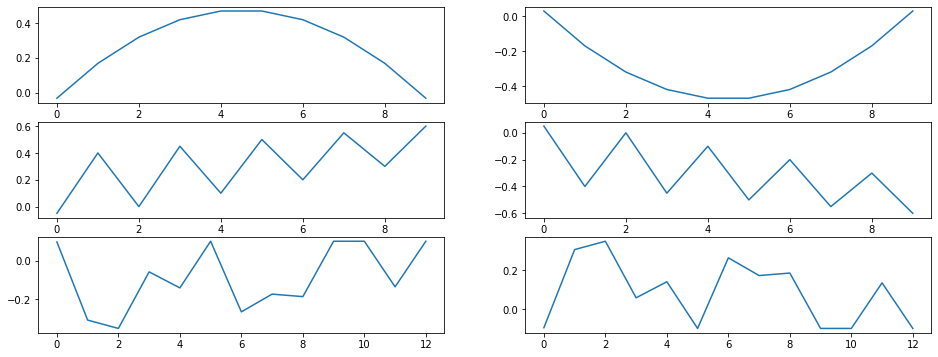

In [3]:
fig, ax = plt.subplots(3,2,figsize=(16, 6))
# fig.suptitle('pattern A')
ax[0,0].plot(range(len(rounding_top)), rounding_top)
ax[0,1].plot(range(len(rounding_bottom)), rounding_bottom)
ax[1,0].plot(range(len(rising_wedge)), rising_wedge)
ax[1,1].plot(range(len(failing_wedge)), failing_wedge)
ax[2,0].plot(range(len(ascending_triangle)), ascending_triangle)
ax[2,1].plot(range(len(decending_triangle)), decending_triangle)

In [4]:
patterns = [rounding_top, rounding_bottom, rising_wedge, failing_wedge, ascending_triangle, decending_triangle]

Each sample in the dataset consists of two sequences that represent the market-induced and stock-specific movement, respectively. The
market-induced sequence is generated by drawing 100 numbers independently from the uniform distribution, U(−1, 1).

The stock-specific sequence is generated in the same way with an extra operation that a number of predefined subsequences are randomly selected to replace some parts of the sequence.

Task 1 (T1): In this task, 0-6 predefined patterns are randomly selected and replace different parts of the stock-specific sequence (7 classes).
Task 2 (T2): In this task, 3 predefined patterns are randomly selected. Therefore, there are 27 different pattern group combinations (27 classes).
Task 3 (T3): In this task, 2 predefined patterns are randomly selected, the time lag between which are selected from {5, 10, 15, 20, 25, 30} (6 classes).


You can loads the pre-generated dataset for reproduce the result in this study. 
You can also use the genete_patterns() function to regenerate datasets:

generate_patterns_1(): generate datasets for T1 in this study.

generate_patterns_2(): generate datasets for T2 in this study.

generate_patterns_3(): generate datasets for T3 in this study.

In [5]:
REPRODUCE = True
if REPRODUCE:
    with open("./datasets/x_1.pkl","rb") as fi:
        x_1 = pickle.load(fi)
    with open("./datasets/market_noise_1.pkl","rb") as fi:
        market_noise_1 = pickle.load(fi)
    with open("./datasets/y_1.pkl","rb") as fi:
        y_1 = pickle.load(fi)
    with open("./datasets/x_2.pkl","rb") as fi:
        x_2 = pickle.load(fi)
    with open("./datasets/market_noise_2.pkl","rb") as fi:
        market_noise_2 = pickle.load(fi)
    with open("./datasets/y_2.pkl","rb") as fi:
        y_2 = pickle.load(fi)
    with open("./datasets/x_3.pkl","rb") as fi:
        x_3 = pickle.load(fi)
    with open("./datasets/market_noise_3.pkl","rb") as fi:
        market_noise_3 = pickle.load(fi)
    with open("./datasets/y_3.pkl","rb") as fi:
        y_3 = pickle.load(fi)
else:
    x_1, y_1 = generate_patterns_1(300,100,patterns)
    market_noise_1 = np.random.random(x_1.shape)
    x_2, y_2 = generate_patterns_2(300,100,patterns)
    market_noise_2 = np.random.random(x_2.shape)
    x_3, y_3 = generate_patterns_3(300,100,patterns)
    market_noise_3 = np.random.random(x_3.shape)
    x_1 = np.expand_dims(x_1,-1)
    x_2 = np.expand_dims(x_2,-1)
    x_3 = np.expand_dims(x_3,-1)
    market_noise_1 = (np.random.rand(x_1.shape[0],x_1.shape[1]) - 0.5) * 2 * np.random.randint(0, 2,size = (x_1.shape[0],1))
    market_noise_2 = (np.random.rand(x_2.shape[0],x_2.shape[1]) - 0.5) * 2 * np.random.randint(0, 2,size = (x_2.shape[0],1))
    market_noise_3 = (np.random.rand(x_3.shape[0],x_3.shape[1]) - 0.5) * 2 * np.random.randint(0, 2,size = (x_3.shape[0],1))
    market_noise_1 = np.expand_dims(market_noise_1,-1)
    market_noise_2 = np.expand_dims(market_noise_2,-1)
    market_noise_3 = np.expand_dims(market_noise_3,-1)


Models are evaluated under 3 three input settings:

• Firm Only: the stock-specific sequence is directly fed
into models.

• Firm and Market: the stock-specific sequence is added
by the market-induced sequence with a probability of 0.5
before being fed into models.

• With MRS: the market-induced sequence and the stock-specific sequence potentially disturbed by it are first
taken by MRS, and the generated stock-specific embedding is fed into models.


In [ ]:
DEVICE = "cuda:" + "0" 
max_epoch = 200
eval_model = SCD
log_file = "./logs/{}_log.txt".format(eval_model.name)
#Change the log_file = False to avoid writing training detail logs.
write_log(log_file, "start", "w")
for n, task in enumerate(zip([x_1,x_2,x_3],[market_noise_1,market_noise_2,market_noise_3],[y_1,y_2,y_3])):
    x, x_market, y = task
    args = {}
    args["input_dim"] = x.shape[-1]
    args["num_class"] = len(np.unique(y))
    args["hid_dim"] = 20 * (1 + (n == 1))
    args["DEVICE"] = DEVICE
    # Firm Only
    args["use_MRS"] = False
    write_log(log_file, "task {}_original".format(n))
    batch_eval(eval_model, args, 
               x, y, 
               lr=0.0005, MAX_EPOCH=max_epoch, check_mode = False, times = 10, log_file = log_file)
    # Firm and Market:
    args["use_MRS"] = False
    write_log(log_file, "task {}_market".format(n))
    batch_eval(eval_model, args, 
               x + x_market, y, 
               lr=0.0005, MAX_EPOCH=max_epoch, check_mode = False, times = 10, log_file = log_file)
    # With MRS:
    args["use_MRS"] = True
    write_log(log_file, "task {}_market_mrs".format(n))
    batch_eval(eval_model, args,
               np.concatenate([x + x_market, x_market], axis = -1), y, 
               lr=0.0005, MAX_EPOCH=max_epoch,check_mode = False, times = 10, log_file = log_file)